## ※ Business analytics tutorial- Dimensionality reduction
---
본 튜토리얼은 고려대학교 강필성 교수님의 Business analytics 수업의 내용을 정리한 튜토리얼 코드 입니다.  
튜토리얼에서는 kernel-based learning의 대표적인 방법론인 **Support Vector Machine(SVM), Support Vector Regression(SVR)** 에 대한 코드와 간단한 설명을 다룹니다.

In [146]:
# 필요 라이브러리 호출
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn.svm import SVC, SVR
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### loan_data를 활용한 실습 SVM 실습
본 실험에서는 대출 연체 여부를 예측하기 위해 구성된 데이터셋인 loan_data를 활용하여 실습을 진행합니다.  
각 변수에 대한 설명은 다음과 같습니다.  
  
<img src="images/loan_data_description.png" width="750px" height="777px" title="loan_data"/>  

본 데이터셋을 활용하여 SVM을 통해 성능을 평가하도록 하겠습니다.

In [107]:
loan_data = pd.read_csv("dataset/loan_data.csv")

In [108]:
# 결측치 확인 -> 결측치가 없으므로 바로 사용

print(loan_data.isnull().sum())

AGE              0
TOT_LOAN         0
TOT_LOAN_CRD     0
LOAN_BNK         0
LOAN_CPT         0
CRDT_CNT         0
GUARN_CNT        0
INCOME           0
LOAN_CRD_CNT     0
LATE_RATE        0
LATE_RATE_1Y     0
INS_MON_MAX      0
CANCEL_CNT_1Y    0
CALL_TIME        0
TEL_COST_MON     0
MOBILE_PRICE     0
SUSP_DAY         0
LATE_TEL         0
COMB_COMM        0
SEX              0
PAY_METHOD       0
JOB              0
TARGET           0
dtype: int64


In [109]:
# 명목형 변수 one-hot encoding 진행

loan_data_one_hot = pd.get_dummies(loan_data)  

In [110]:
# 연속형 변수 normalization -> Standard scaler를 활용하여 normalization 진행

continuous_variable = ['AGE', 'TOT_LOAN', 'TOT_LOAN_CRD', 'LOAN_BNK', 'LOAN_CPT', 
'CRDT_CNT','GUARN_CNT', 'INCOME', 'LOAN_CRD_CNT', 'LATE_RATE', 'LATE_RATE_1Y',
'INS_MON_MAX', 'CANCEL_CNT_1Y', 'CALL_TIME', 'TEL_COST_MON','MOBILE_PRICE', 
'SUSP_DAY', 'LATE_TEL']

loan_data_continuos = loan_data_one_hot[continuous_variable]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler = scaler.fit(loan_data_continuos)
loan_data_continuos_scaled = scaler.transform(loan_data_continuos)

#scale 연속형 변수 dataframe화
dataframe_continuous = pd.DataFrame(loan_data_continuos_scaled,
 columns= continuous_variable)

# scale 연속형 변수와 명목형 변수 합치기
dataframe_scaled = pd.concat([dataframe_continuous, loan_data_one_hot.drop(columns=continuous_variable)], axis =1)


### KFOLD validation을 통한 hyperparameter 탐색  
KFold validation을 통해 hyperparameter를 탐색하기에 앞서 각 hyperparameter들의 구체적인 의미를 살펴보고자 합니다.  
모든 Kernel에 사용되는 hyperparameter와 특정 kernel에서 사용되는 hyperparameter를 구분하여 설명하면 다음과 같습니다.  

- 모든 Kernel에 적용되는 Hyperparameter

    - C(penalty)    
    C는 '얼마나 많은 데이터 샘플이 다른 클래스에 놓이는 것을 허용하는지를 결정' 하는 hyperparameter입니다.  
    C의 값이 큰 경우 penalty를 줄이는 방향으로 학습이 진행되므로 margin이 좁게 형성됩니다.  
    반대로 C의 값이 작은 경우 penalty를 받더라도 margin을 넓게 잡도록 학습이 됩니다.  
    즉 C의 값을 작게 설정하면 어느정도 오류를 허용하며 C의 값을 크게 설정하면 오류를 최대한 줄이는 방향으로 분류경계면이 형성됩니다.  

    - Max_iter    
    Iteration을 최대 몇번까지 진행할지 정해주는 hyperparameter입니다.

- Kernel 별 Hyperparameter 정리    
  
    - Linear  
    공통 hyperparameter 이외에는 없음   

    - Poly    
    degree: 다항식의 차수를 의미하며 차수가 높을수록 복잡한 분류경계면이 생성

    - Rbf    
    gamma: gamma는 데이터 샘플이 영향력을 주는 거리를 결정하는 역할을 하며 가우시안 함수의 분산을 조정하는 역할을 합니다.  
    
        <img src="images/gamma에 따른 분포 변화.png" width="742px" height="420px" title="gamma에 따른 변화">  
    
    즉 gamma의 값이 클수록 분산이 작아지는 것을 알 수 있습니다.  
    Rbf kernel의 경우에서 C, gamma 값에 따른 분류경계면의 변화를 살펴보면 아래 그림과 같습니다.  

    <img src="images/c_gamma_effect.png" width="742px" height="770px" title="loan_data">  

    C의 값이 커짐에 따라 오분류를 허용하지 않기 위해 분류경계면의 모양이 복잡해짐을 알 수 있습니다.  
    또한 gamma의 값 역시 값이 커질수록 분류 경계면의 모양이 복잡해지는 것을 확인 할 수 있었습니다.  
    다만 복잡해지는 방향이 조금 다른 것을 확인 할 수 있었다. C 값의 경우 돌출 되어 있는 부분의 개수는 유지하면서 모양이 뾰족해지면서 복잡해지지만, gamma 값의 경우 돌출 되어 있는 부분의 개수가 늘어나면서 모양이 복잡해짐을 확인 할 수 있었습니다.  


위에서 설명한 hyperparameter들에 대하여 kfold validation을 통해 최적의 hyperparameter 조합을 찾고 성능을 산출합니다.




In [111]:
# train dataset, test dataset 분리
test_size = 0.2
test_num = int(dataframe_scaled.shape[0] * test_size)
train_num = dataframe_scaled.shape[0] - test_num
train_idx = np.random.choice(dataframe_scaled.shape[0], train_num, replace=False)
test_idx = np.setdiff1d(range(dataframe_scaled.shape[0]), train_idx)

train_dataset = dataframe_scaled.iloc[train_idx]
test_dataset = dataframe_scaled.iloc[test_idx]


In [112]:
# Kfold validation 라이브러리 호출 및 fold 개수 설정, num_fold = 5

from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
num_fold = 5
kfold = KFold(n_splits=num_fold, random_state=42, shuffle= True)
n_iter = 0
features = train_dataset.drop(columns = ['TARGET'])
label= train_dataset['TARGET']

In [113]:
def train(features, label, model):
  score_list = []
  n_iter = 0
  for train_idx, test_idx in kfold.split(features, label):
    
    X_train, X_test = features.iloc[train_idx], features.iloc[test_idx]
    y_train, y_test = label.iloc[train_idx], label.iloc[test_idx]

    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    score = accuracy_score(y_test, preds)

    score_list.append(score)

    total_score = float(sum(score_list)/len(score_list))
  
  return total_score

### KFOLD validation 진행  
- 모든 Kernel에 적용되는 Hyperparameter

    - C(penalty)    
    C는 [1,10,100,1000] 총 4가지의 값을 기준으로 hyperparameter 탐색을 진행

    - Max_iter    
    Max_iter는 10000으로 고정 후 실험을 진행

- Kernel 별 Hyperparameter 정리    
  
    - Linear  
    공통 hyperparameter 이외에는 없음   

    - Poly    
    degree: [2,4,6,8] 총 4가지의 값을 기준으로 hyperparameter 탐색을 진행

    - Rbf    
    gamma: [1,10,100,1000] 총 4가지의 값을 기준으로 hyperparameter 탐색을 진행

In [114]:
kernel_list = ['linear', 'rbf', 'poly']
c_list = [1,10,100,1000]
degree_list = [2,4,6,8]
gamma_list = [1,10,100,1000]
max_iter = 10000

In [187]:
kfold_result_dict = {}

for kernel in kernel_list:
    for C in c_list:
        if kernel == 'linear':
            model = svm.SVC(kernel = kernel, C=C, max_iter = max_iter)
            model_name = f"{kernel}_C_{C}"
            kfold_result = train(features, label, model)
            kfold_result_dict[model_name] = kfold_result
            print(f"{model_name}의 kfold validation acc 결과는 {round(kfold_result, 4)} 입니다.")
        
        elif kernel == 'rbf':
            for gamma in gamma_list:
                model = svm.SVC(kernel = kernel, C=C, gamma = gamma, max_iter = max_iter)
                model_name = f"{kernel}_C_{C}_gamma_{gamma}"
                kfold_result = train(features, label, model)
                kfold_result_dict[model_name] = kfold_result
                print(f"{model_name}의 kfold validation acc 결과는 {round(kfold_result, 4)} 입니다.")
        
        elif kernel == 'poly':
            for degree in degree_list:
                model = svm.SVC(kernel = kernel, C=C, degree = degree, max_iter = max_iter)
                model_name = f"{kernel}_C_{C}_degree_{degree}"
                kfold_result = train(features, label, model)
                kfold_result_dict[model_name] = kfold_result
                print(f"{model_name}의 kfold validation acc 결과는 {round(kfold_result, 4)} 입니다.")
            
            

linear_C_1의 kfold validation acc 결과는 0.6304 입니다.
linear_C_10의 kfold validation acc 결과는 0.3335 입니다.
linear_C_100의 kfold validation acc 결과는 0.486 입니다.
linear_C_1000의 kfold validation acc 결과는 0.4898 입니다.
rbf_C_1_gamma_1의 kfold validation acc 결과는 0.9056 입니다.
rbf_C_1_gamma_10의 kfold validation acc 결과는 0.9052 입니다.
rbf_C_1_gamma_100의 kfold validation acc 결과는 0.9052 입니다.
rbf_C_1_gamma_1000의 kfold validation acc 결과는 0.9052 입니다.
rbf_C_10_gamma_1의 kfold validation acc 결과는 0.9023 입니다.
rbf_C_10_gamma_10의 kfold validation acc 결과는 0.9051 입니다.
rbf_C_10_gamma_100의 kfold validation acc 결과는 0.9052 입니다.
rbf_C_10_gamma_1000의 kfold validation acc 결과는 0.9052 입니다.
rbf_C_100_gamma_1의 kfold validation acc 결과는 0.902 입니다.
rbf_C_100_gamma_10의 kfold validation acc 결과는 0.9051 입니다.
rbf_C_100_gamma_100의 kfold validation acc 결과는 0.9052 입니다.
rbf_C_100_gamma_1000의 kfold validation acc 결과는 0.9052 입니다.
rbf_C_1000_gamma_1의 kfold validation acc 결과는 0.902 입니다.
rbf_C_1000_gamma_10의 kfold validation acc 결과는 0.9051 입니다.
rbf_C_10

In [190]:
result_dataframe = pd.DataFrame([*kfold_result_dict.values()], index= [*kfold_result_dict.keys()], columns=["Accuracy"])

In [191]:
result_dataframe

,Accuracy
linear_C_1,0.630408
linear_C_10,0.333486
linear_C_100,0.486036
linear_C_1000,0.489751
rbf_C_1_gamma_1,0.905615
rbf_C_1_gamma_10,0.905212
rbf_C_1_gamma_100,0.905212
rbf_C_1_gamma_1000,0.905212
rbf_C_10_gamma_1,0.902331
rbf_C_10_gamma_10,0.905068


### Kfold validation 결과 분석 및 hyperparameter 선택  

- Linear kernel

    Linear kernel의 경우 C값에 민감하게 성능이 바뀜을 확인 할 수 있었습니다.  
    이진 분류 task임을 감안했을때, 정확도가 50%보다 작으면 random classifier보다도 높지 않은 성능이므로 분류기의 역할을 하지 못한다고 할 수 있습니다. 전반적으로 성능이 높지 않고 정확도가 50%보다 낮은 조합도 많았으므로 linear kernel은 본 데이터셋에서 잘 작동하지 않는다는 결론을 내릴 수 있었습니다.  
    Search space 안에서 가장 좋은 성능을 보였던 C값은 1 이었습니다.  
    따라서 C = 1 로 설정하고 test를 진행합니다.  
    
- Poly kernel

    Poly kernel의 경우도 hyperparameter에 따라 민감하게 성능이 바뀜을 확인 할 수 있었습니다.  
    성능이 좋은 경우도 종종 있었지만 정확도가 50%가 안되는 경우도 상당히 많았습니다.  
    즉 hyperparameter를 신중하게 선택하여야 잘 작동하는 구조라는 결론을 내릴 수 있었습니다.  
    Best 조합은 C = 1, degree = 2 인 경우였습니다.  
    따라서 C = 1, degree = 2 로 설정하여 test를 진행합니다.  

- Rbf kernel

    Rbf kernel의 경우는 다른 kernel에 비해 hyperparameter에 민감하게 성능이 바뀌지 않았습니다.  
    모든 hyperparameter 조합에서 90%이상의 accuracy를 보이며, robust하게 잘 작동하는 것을 확인하였습니다.  
    Best 조합은 C = 1, gamma = 1 인 경우였습니다.  
    따라서 C = 1, gamma = 1 로 설정하여 test를 진행합니다.  


### Testset을 통한 최종 성능 도출

In [139]:
def test(model):
    
    X_train, X_test = train_dataset.drop(columns = ['TARGET']), test_dataset.drop(columns = ['TARGET'])
    y_train, y_test = train_dataset['TARGET'], test_dataset['TARGET']

    model.fit(X_train, y_train)
    
    # acc 측정을 위한 score 계산
    preds = model.predict(X_test)
    score = accuracy_score(y_test, preds)
  
    return score

In [142]:
test_result_dict = {}

for kernel in kernel_list:
    if kernel == 'linear':
        model = svm.SVC(kernel = kernel, C=1, max_iter = max_iter)
        model_name = f"{kernel}_best_combination"
        test_result = test(model)
        test_result_dict[model_name] = test_result
        print(f"{model_name}의 test acc 결과는 {round(test_result, 4)} 입니다.")
    
    elif kernel == 'rbf':
        model = svm.SVC(kernel = kernel, C=1, gamma = 1, max_iter = max_iter)
        model_name = f"{kernel}_best_combination"
        test_result = test(model)
        test_result_dict[model_name] = test_result
        print(f"{model_name}의 test acc 결과는 {round(test_result, 4)} 입니다.")
    
    elif kernel == 'poly':
        model = svm.SVC(kernel = kernel, C=1, degree = 2, max_iter = max_iter)
        model_name = f"{kernel}_best_combination"
        test_result = test(model)
        test_result_dict[model_name] = test_result
        print(f"{model_name}의 test acc 결과는 {round(test_result, 4)} 입니다.")

linear_best_combination의 test acc 결과는 0.4693 입니다.
rbf_best_combination의 test acc 결과는 0.907 입니다.
poly_best_combination의 test acc 결과는 0.9147 입니다.


In [147]:
def draw_roc_curve(kernel):
    X_train, X_test = train_dataset.drop(columns = ['TARGET']), test_dataset.drop(columns = ['TARGET'])
    y_train, y_test = train_dataset['TARGET'], test_dataset['TARGET']

    if kernel == 'linear':
        model = svm.SVC(kernel = kernel, C=1, max_iter = max_iter)
    
    elif kernel == 'rbf':
        model = svm.SVC(kernel = kernel, C=1, gamma = 1, max_iter = max_iter)
    
    elif kernel == 'poly':
        model = svm.SVC(kernel = kernel, C=1, degree = 2, max_iter = max_iter)
        
    model.fit(X_train, y_train)
    
    y_train_pred = model.decision_function(X_train)    
    y_test_pred = model.decision_function(X_test)
    train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
    test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)
    plt.grid()

    plt.plot(train_fpr, train_tpr, label=" AUC TRAIN ="+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
    plt.plot([0,1],[0,1],'g--')
    plt.legend()
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"AUC(ROC curve)_{kernel}")
    plt.grid(color='black', linestyle='-', linewidth=0.5)
    plt.show()

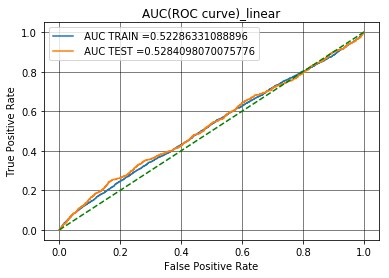

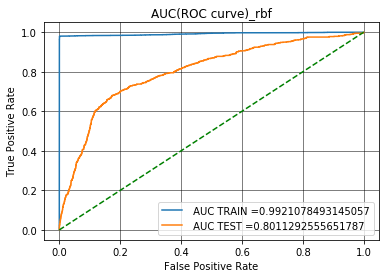

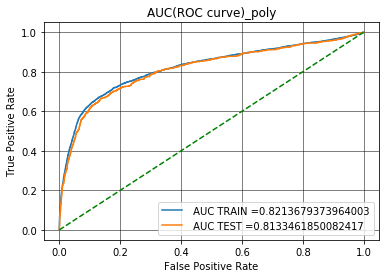

In [148]:
for kernel in kernel_list:
    draw_roc_curve(kernel)

### 실험결과
linear kernel을 사용한 경우를 제외하고는 90%가 넘는 정확도를 달성하였습니다.  
이진 분류 작업임을 고려했을 때도 이는 굉장히 높은 정확도이며 분류기의 역할을 잘 수행하고 있음을 알 수 있었습니다. linear kernel의 경우 정확도가 46.93%가 나왔는데, 이는 random classifier보다 낮은 성능이므로 분류기의 역할을 제대로 수행하지 못함을 확인 할 수 있습니다.  

한편 ROC curve를 통해 poly kernel을 사용한 경우가 가장 높은 AUC값을 가짐을 확인 할 수 있었습니다.  
poly kernel의 경우 testset의 AUC값을 0.81을 기록하였고, trainset의 경우 0.82를 기록하였습니다. 값의 차이가 거의 없는것으로 보아 과적합 되지 않고 적절히 학습이 된 것을 확인 할 수 있었습니다.  

rbf kernel의 경우 testset의 AUC값을 0.80을 기록하였고, trainset의 경우 0.99를 기록하였습니다.  
trainset의 성능이 훨씬 더 높은 것으로 보아 분류기가 과적합되었음을 예상할 수 있었습니다.


### boston dataset을 활용한 SVR 실습  
본 실습에서는 Boston dataset을 활용하여 SVR을 통한 Boston 집값 예측 실습을 진행합니다.  
실습에서 사용하는 boston dataset의 변수에 대한 설명은 다음과 같습니다.  

<img src="images/boston_description.png" width="744px" height="356px" title="boston_data"/>  

위의 dataset을 활용하여 SVR을 통해 성능 평가를 진행하려고 합니다.



In [117]:
from sklearn.datasets import load_iris, load_boston

boston = load_boston()

In [118]:
boston_df = pd.DataFrame(boston.data, columns=boston.feature_names)
boston_target = pd.DataFrame(boston.target, columns=['target'])

In [119]:
boston_target.mean()

target    22.532806
dtype: float64

In [120]:
# 결측치 확인 -> 결측치가 없으므로 바로 사용

print(boston_df.isnull().sum())

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
dtype: int64


In [121]:
boston_df.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT'],
      dtype='object')

In [122]:
# 연속형 변수 normalization -> Standard scaler를 활용하여 normalization 진행

continuous_variable = ['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX','PTRATIO', 'B', 'LSTAT']

boston_continuos = boston_df[continuous_variable]

scaler = StandardScaler()
scaler = scaler.fit(boston_continuos)
boston_continuos_scaled = scaler.transform(boston_continuos)

#scale 연속형 변수 dataframe화
dataframe_continuous = pd.DataFrame(boston_continuos_scaled, columns= continuous_variable)

# scale 연속형 변수와 명목형 변수 합치기
dataframe_scaled = pd.concat([dataframe_continuous, boston_df.drop(columns=continuous_variable)], axis =1)

### KFOLD validation을 통한 hyperparameter 탐색 
SVR은 SVM의 regression 버전입니다.  
따라서 굉장히 유사한 형태로 진행이 되지만 regression과 classification의 task 차이로 인해 조금은 다른 hyperparameter를 갖습니다.  
SVM에서의 설명과 마찬가지로 모든 Kernel에 사용되는 hyperparameter와 특정 kernel에서 사용되는 hyperparameter를 구분하여 설명하면 다음과 같습니다.  

- 모든 Kernel에 적용되는 Hyperparameter

    - C(penalty)    
    SVM과 같이 Penalty를  C는 '얼마나 많은 데이터 샘플이 다른 클래스에 놓이는 것을 허용하는지를 결정' 하는 hyperparameter이다. SVR의 목적함수는 아래와 같습니다.  

        <img src="images/svr_obj_func.png" width="380px" height="83px" title="svr_obj_func">  

    SVR의 목적함수를 생각하면, C의 값을 regularization을 얼마나 할지에 대한 가중치로도 생각할 수 있다.  
    C의 값이 커지면 상대적으로 회귀식의 파라미터에 대한 중요도가 떨어지고, C의 값이 작아지면 상대적으로 회귀식의 파라미터에 대한 중요도가 증가합니다. 따라서 C의 값을 통해 regularization의 효과를 가질 수 있습니다.
    
    - Epsilon    
    SVR의 경우 Epsilon-tube 내부의 오차는 허용을 해주는데, 이때 tube의 폭의 절반이 'Epsilon' 입니다.  

- Kernel 별 Hyperparameter 정리    
  
    - Linear  
    공통 hyperparameter 이외에는 없음   

    - Poly    
    degree: 다항식의 차수를 의미하며 차수가 높을수록 복잡한 분류경계면이 생성

    - Rbf    
    gamma: gamma는 데이터 샘플이 영향력을 주는 거리를 결정하는 역할을 하며 가우시안 함수의 분산을 조정하는 역할을 합니다.  
    
위에서 설명한 hyperparameter들에 대하여 kfold validation을 통해 최적의 hyperparameter 조합을 찾고 성능을 산출다.


In [123]:
# train dataset, test dataset 분리

test_size = 0.2
test_num = int(dataframe_scaled.shape[0] * test_size)
train_num = dataframe_scaled.shape[0] - test_num
train_idx = np.random.choice(dataframe_scaled.shape[0], train_num, replace=False)
test_idx = np.setdiff1d(range(dataframe_scaled.shape[0]), train_idx)

features_train = dataframe_scaled.iloc[train_idx]
target_train = boston_target.iloc[train_idx]
features_test = dataframe_scaled.iloc[test_idx]
target_test = boston_target.iloc[test_idx]



In [124]:
# Kfold validation 라이브러리 호출 및 fold 개수 설정, num_fold = 5

num_fold = 5
kfold = KFold(n_splits=num_fold, random_state=42, shuffle= True)

In [125]:
def train(features_train, target_train, model):
    """
    train dataset을 통해 model별 MSE loss를 산출하는 함수
    """
    loss_list = []
    for train_idx, test_idx in kfold.split(features_train, target_train):
        
        X_train, X_test = features_train.iloc[train_idx], features_train.iloc[test_idx]
        y_train, y_test = target_train.iloc[train_idx], target_train.iloc[test_idx]

        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        mse_loss = np.mean(np.square(y_test['target'].values-preds))
        
        loss_list.append(mse_loss)

        total_loss = float(sum(loss_list)/len(loss_list))
    
    return total_loss

### KFOLD validation 진행  
- 모든 Kernel에 적용되는 Hyperparameter

    - C(penalty)    
    C는 [1,10,100,1000] 총 4가지의 값을 기준으로 hyperparameter 탐색을 진행

    - Epsilon
    Epsilon은 [0.1, 0.2, 0.3, 0.4] 총 4가지의 값을 기준으로 hyperparameter 탐색을 진행

    - Max_iter    
    Max_iter는 10000으로 고정 후 실험을 진행

- Kernel 별 Hyperparameter 정리    
  
    - Linear  
    공통 hyperparameter 이외에는 없음   

    - Poly    
    degree: [2,4,6,8] 총 4가지의 값을 기준으로 hyperparameter 탐색을 진행

    - Rbf    
    gamma: [1,10,100,1000] 총 4가지의 값을 기준으로 hyperparameter 탐색을 진행

In [60]:
kernel_list = ['linear', 'rbf', 'poly']
c_list = [1,10,100,1000]
e_list = [0.1, 0.2, 0.3, 0.4]
degree_list = [2,4,6,8]
gamma_list = [1,10,100,1000]
max_iter = 10000
kfold_result_dict = {}

for kernel in kernel_list:
    for C in c_list:
        for e in e_list:
            if kernel == 'linear':
                model = svm.SVR(kernel = kernel, C=C, epsilon = e, max_iter = max_iter)
                model_name = f"{kernel}_C_{C}_epsilon_{e}"
                kfold_result = train(features_train, target_train, model)
                kfold_result_dict[model_name] = kfold_result
                print(f"{model_name}의 kfold validation mse_loss는 {round(kfold_result, 2)} 입니다.")
            
            elif kernel == 'rbf':
                for gamma in gamma_list:
                    model = svm.SVR(kernel = kernel, C=C, gamma = gamma, max_iter = max_iter)
                    model_name = f"{kernel}_C_{C}_epsilon_{e}_gamma_{gamma}"
                    kfold_result = train(features_train, target_train, model)
                    kfold_result_dict[model_name] = kfold_result
                    print(f"{model_name}의 kfold validation mse_loss는 {round(kfold_result, 2)} 입니다.")
            
            elif kernel == 'poly':
                for degree in degree_list:
                    model = svm.SVR(kernel = kernel, C=C, degree = degree, max_iter = max_iter)
                    model_name = f"{kernel}_C_{C}_epsilon_{e}_degree_{degree}"
                    kfold_result = train(features_train, target_train, model)
                    kfold_result_dict[model_name] = kfold_result
                    print(f"{model_name}의 kfold validation mse_loss는 {round(kfold_result, 2)} 입니다.")
            
            

linear_C_1_epsilon_0.1의 kfold validation mse_loss는 26.0 입니다.
linear_C_1_epsilon_0.2의 kfold validation mse_loss는 25.81 입니다.
linear_C_1_epsilon_0.3의 kfold validation mse_loss는 25.68 입니다.
linear_C_1_epsilon_0.4의 kfold validation mse_loss는 25.71 입니다.
linear_C_10_epsilon_0.1의 kfold validation mse_loss는 25.97 입니다.
linear_C_10_epsilon_0.2의 kfold validation mse_loss는 25.81 입니다.
linear_C_10_epsilon_0.3의 kfold validation mse_loss는 25.54 입니다.
linear_C_10_epsilon_0.4의 kfold validation mse_loss는 25.6 입니다.
linear_C_100_epsilon_0.1의 kfold validation mse_loss는 26.8 입니다.
linear_C_100_epsilon_0.2의 kfold validation mse_loss는 27.98 입니다.
linear_C_100_epsilon_0.3의 kfold validation mse_loss는 30.17 입니다.
linear_C_100_epsilon_0.4의 kfold validation mse_loss는 26.65 입니다.
linear_C_1000_epsilon_0.1의 kfold validation mse_loss는 61.5 입니다.
linear_C_1000_epsilon_0.2의 kfold validation mse_loss는 69.9 입니다.
linear_C_1000_epsilon_0.3의 kfold validation mse_loss는 51.78 입니다.
linear_C_1000_epsilon_0.4의 kfold validation mse_loss는 

In [61]:
result_dataframe = pd.DataFrame([*kfold_result_dict.values()], index= [*kfold_result_dict.keys()], columns=["MSE"])

In [62]:
result_dataframe

,MSE
linear_C_1_epsilon_0.1,2.600425e+01
linear_C_1_epsilon_0.2,2.581098e+01
linear_C_1_epsilon_0.3,2.567595e+01
linear_C_1_epsilon_0.4,2.570875e+01
linear_C_10_epsilon_0.1,2.597317e+01
linear_C_10_epsilon_0.2,2.580535e+01
linear_C_10_epsilon_0.3,2.553532e+01
linear_C_10_epsilon_0.4,2.560295e+01
linear_C_100_epsilon_0.1,2.680085e+01
linear_C_100_epsilon_0.2,2.798089e+01


조합의 수가 많아 dataframe의 가시성이 안 좋으므로, Kernel 별로 나누어 dataframe을 생성하였고 그 결과는 다음과 같습니다.

In [78]:
linear_result_dict = {}
poly_result_dict = {}
rbf_result_dict = {}

for key in kfold_result_dict.keys():
    if 'linear' in key:
        linear_result_dict[key] = kfold_result_dict[key]
    elif 'rbf' in key:
        rbf_result_dict[key] = kfold_result_dict[key]
    elif 'poly' in key:
        poly_result_dict[key] = kfold_result_dict[key]

In [89]:
linear_result_dataframe = pd.DataFrame([*linear_result_dict.values()], index= [*linear_result_dict.keys()], columns=["MSE"])
linear_result_dataframe

,MSE
linear_C_1_epsilon_0.1,26.004251
linear_C_1_epsilon_0.2,25.810979
linear_C_1_epsilon_0.3,25.675954
linear_C_1_epsilon_0.4,25.708746
linear_C_10_epsilon_0.1,25.973173
linear_C_10_epsilon_0.2,25.805351
linear_C_10_epsilon_0.3,25.535319
linear_C_10_epsilon_0.4,25.602954
linear_C_100_epsilon_0.1,26.800850
linear_C_100_epsilon_0.2,27.980889


In [94]:
linear_result_dataframe.idxmin()

MSE    linear_C_10_epsilon_0.3
dtype: object

In [84]:
rbf_result_dataframe = pd.DataFrame([*rbf_result_dict.values()], index= [*rbf_result_dict.keys()], columns=["MSE"])
rbf_result_dataframe

,MSE
rbf_C_1_epsilon_0.1_gamma_1,73.099990
rbf_C_1_epsilon_0.1_gamma_10,88.978231
rbf_C_1_epsilon_0.1_gamma_100,89.811992
rbf_C_1_epsilon_0.1_gamma_1000,89.825624
rbf_C_1_epsilon_0.2_gamma_1,73.099990
rbf_C_1_epsilon_0.2_gamma_10,88.978231
rbf_C_1_epsilon_0.2_gamma_100,89.811992
rbf_C_1_epsilon_0.2_gamma_1000,89.825624
rbf_C_1_epsilon_0.3_gamma_1,73.099990
rbf_C_1_epsilon_0.3_gamma_10,88.978231


In [95]:
rbf_result_dataframe.idxmin()

MSE    rbf_C_100_epsilon_0.1_gamma_1
dtype: object

In [85]:
poly_result_dataframe = pd.DataFrame([*poly_result_dict.values()], index= [*poly_result_dict.keys()], columns=["MSE"])
poly_result_dataframe

,MSE
poly_C_1_epsilon_0.1_degree_2,4.654189e+01
poly_C_1_epsilon_0.1_degree_4,4.339989e+01
poly_C_1_epsilon_0.1_degree_6,1.018579e+02
poly_C_1_epsilon_0.1_degree_8,1.702326e+03
poly_C_1_epsilon_0.2_degree_2,4.654189e+01
poly_C_1_epsilon_0.2_degree_4,4.339989e+01
poly_C_1_epsilon_0.2_degree_6,1.018579e+02
poly_C_1_epsilon_0.2_degree_8,1.702326e+03
poly_C_1_epsilon_0.3_degree_2,4.654189e+01
poly_C_1_epsilon_0.3_degree_4,4.339989e+01


In [96]:
poly_result_dataframe.idxmin()

MSE    poly_C_10_epsilon_0.1_degree_2
dtype: object

### Kfold validation 결과 분석 및 hyperparameter 선택  

- Linear kernel

    Linear kernel의 경우 SVM과는 달리 타 kernel에 비해 C값에 민감하게 성능이 바뀌지 않았습니다.
    Search space 안에서 가장 좋은 성능을 보였던 C, Epsilon 조합은 C = 10, Epsilon = 0.3 입니다.
    따라서 C = 10, Epsilon = 0.3 로 설정하고 test를 진행합니다.  
    
- Poly kernel

    Poly kernel의 경우는 hyperparameter에 따라 민감하게 성능이 바뀜을 확인 할 수 있었습니다.  
    Best 조합은 C = 10, Epsilon = 0.1, degree = 2 인 경우였습니다.  
    따라서 C = 10, Epsilon = 0.1, degree = 2 로 설정하여 test를 진행합니다.  

- Rbf kernel

    Rbf kernel의 경우도 hyperparameter에 따라 민감하게 성능이 바뀜을 확인 할 수 있었습니다. 
    Best 조합은 C = 100, Epsilon = 0.1, gamma = 1 인 경우였습니다.  
    따라서 C = 100, Epsilon = 0.1, gamma = 1 로 설정하여 test를 진행합니다.  

In [133]:
def test(model):
    
    X_train, X_test = features_train, features_test
    y_train, y_test = target_train, target_test

    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mse_loss = np.mean(np.square(y_test['target'].values-preds))
    mape_loss = np.mean(np.abs((y_test['target'].values-preds)/y_test['target'].values))*100
    return mse_loss, mape_loss

In [136]:
test_result_dict = {}

for kernel in kernel_list:
    model_name = f"{kernel}_best_combination"
    if kernel == 'linear':
        model = svm.SVR(kernel = kernel, C=10, epsilon= 0.3 ,max_iter = max_iter)
        test_result, mape_loss = test(model)
        test_result_dict[model_name] = test_result
        print(f"{model_name}의 test mse는 {round(test_result, 2)} 입니다.")
        print(f"{model_name}의 test rmse는 {round(test_result**0.5, 2)} 입니다.")
        print(f"{model_name}의 test mape는 {round(mape_loss, 2)}% 입니다.")
        print("-"*60)
    
    elif kernel == 'rbf':
        model = svm.SVR(kernel = kernel, C=100, epsilon= 0.1, gamma = 1, max_iter = max_iter)
        test_result, mape_loss = test(model)
        test_result_dict[model_name] = test_result
        print(f"{model_name}의 test mse는 {round(test_result, 2)} 입니다.")
        print(f"{model_name}의 test rmse는 {round(test_result**0.5, 2)} 입니다.")
        print(f"{model_name}의 test mape는 {round(mape_loss, 2)}% 입니다.")
        print("-"*60)
    
    elif kernel == 'poly':
        model = svm.SVR(kernel = kernel, C=10, epsilon= 0.1, degree = 2, max_iter = max_iter)
        test_result, mape_loss = test(model)
        test_result_dict[model_name] = test_result
        print(f"{model_name}의 test mse는 {round(test_result, 2)} 입니다.")
        print(f"{model_name}의 test rmse는 {round(test_result**0.5, 2)} 입니다.")
        print(f"{model_name}의 test mape는 {round(mape_loss, 2)}% 입니다.")
        print("-"*60)

linear_best_combination의 test mse는 18.84 입니다.
linear_best_combination의 test rmse는 4.34 입니다.
linear_best_combination의 test mape는 13.88% 입니다.
------------------------------------------------------------
rbf_best_combination의 test mse는 29.56 입니다.
rbf_best_combination의 test rmse는 5.44 입니다.
rbf_best_combination의 test mape는 17.34% 입니다.
------------------------------------------------------------
poly_best_combination의 test mse는 24.06 입니다.
poly_best_combination의 test rmse는 4.91 입니다.
poly_best_combination의 test mape는 16.21% 입니다.
------------------------------------------------------------


### 실험결과
각 kernel 별 model의 성능을 확인하기 위해 mse, rmse, mape를 산출하였습니다.  
train의 경우 mse를 기준으로 최적의 hyperparameter 조합을 찾았지만, test의 경우 실제로 각 model이 어느 정도의 성능을 보여주고 있는지 가시적으로 표현할 필요가 있으므로 rmse, mape를 추가하였습니다.  
mape를 기준으로 보았을때 각 kernel 별 모델 모두 10~20% 사이의 오차를 보이고 있으며 linear, poly, rbf 순으로 우수한 성능을 보이고 있습니다.  
앞의 loan dataset을 이용한 실험과는 상반되는 결과입니다. 개인적인 견해로는 dataset의 수에서 온 차이라고 생각합니다. 일반적으로 복잡한 모델을 쓸수록 data의 개수가 많아야 잘 작동하는데 loan dataset의 경우 약 50,000개의 data를 포함하고 있고, boston dataset의 경우 약 500개의 data를 포함하고 있습니다. 즉 boston dataset의 경우 data의 수가 상당히 적은 dataset이므로 상대적으로 단순한 kernel인 linear kernel을 사용하여 예측을 한 것이 더 높은 성능을 보인것이라고 예상합니다. 
